In [ ]:
# If the import cell below says you don't have scikit-learn (sklearn), best to install using conda and the terminal.
# Open a new terminal window. Run the following `conda install scikit-learn` then try running the import cell again.
# Visit `https://scikit-learn.org/stable/install.html` for more help.

In [ ]:
# Portions of today's lesson were adapted from materials developed by Matt Drury

# fredhutch.io -- Intermediate Python: Machine Learning
Fred Hutchinson Cancer Research Center

# Week 2 -- Case Study in Regression
We have access to a set of data describing a variety of features about people's commutes. We're hoping to use these data to predict how long a new person's commute will be given some information about them. Can machine learning help us achieve our goal?

### By the end of today's class, you should be able to:
* Visualize single variables in different ways and plot continuous features against categorical features to highlight notable patterns (this lesson isn't about plotting specifically, but I'm hoping the plots here will help you create your own)
* Engineer new features (columns) for our dataset using existing features and/or specific functions written for that purpose
* Set-up, fit, and evaluate different models for our problem, including linear regression and random forests
* Understand the basic structure and some of the strengths and draw-backs of the two models we fitted

### Throughout we've scattered pairs of cells like the 2 immediately below. Use them to note your thoughts, answers to questions, and the code you're experimenting with.
(remember that you can change the type of a cell by going into command mode (cell highlighted in blue) and pressing `m` for markdown and `y` for code)

__________
Notes (markdown):

In [1]:
# Scratch area (code)

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
import matplotlib.pyplot as plt

# Read in Raw Data

### FIXME: No solution to commented question

In [3]:
TRAIN_DATA_PATH = '../data/commute-times-train.csv'
TEST_DATA_PATH = '../data/commute-times-test.csv'
# Why might it be helpful to save these paths strings to variables?

In [4]:
train_data_raw = pd.read_csv(TRAIN_DATA_PATH, 
                             parse_dates=['time_of_day_ts'])
test_data_raw = pd.read_csv(TEST_DATA_PATH,
                            parse_dates=['time_of_day_ts'])

# Raw Data (One Variable) Visualizations

### FIXME: What is the point of this visualization

## Source and Destination of Commute

Text(0.5, 1.0, 'Destination Of Commute Lat, Long')

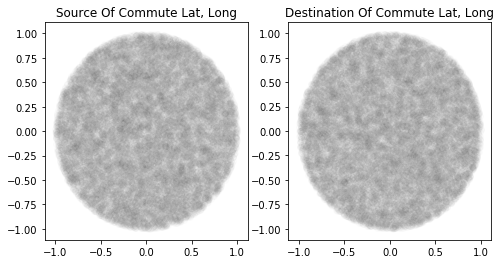

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(train_data_raw['source_latitude'],
               train_data_raw['source_longitude'],
               color="grey", alpha=0.02)
axs[0].set_title("Source Of Commute Lat, Long")
axs[1].scatter(train_data_raw['destination_latitude'],
               train_data_raw['destination_longitude'],
               color="grey", alpha=0.02)
axs[1].set_title("Destination Of Commute Lat, Long")

## Count of Commute Types

Text(0, 0.5, 'Volume of Commutes')

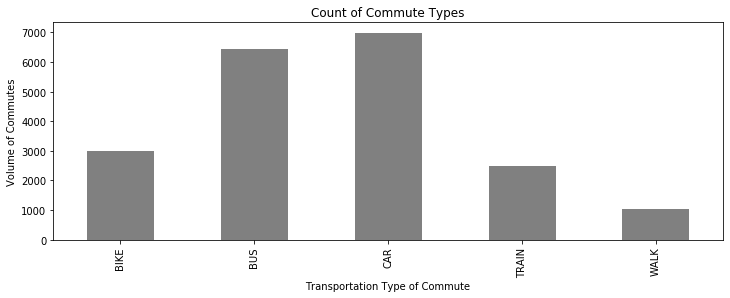

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw.groupby('commute_type').size().plot(
    ax=ax, kind='bar', color="grey")
ax.set_title("Count of Commute Types")
ax.set_xlabel("Transportation Type of Commute")
ax.set_ylabel("Volume of Commutes")

## Distribution of Commute Time

Text(0, 0.5, 'Volume of Commutes')

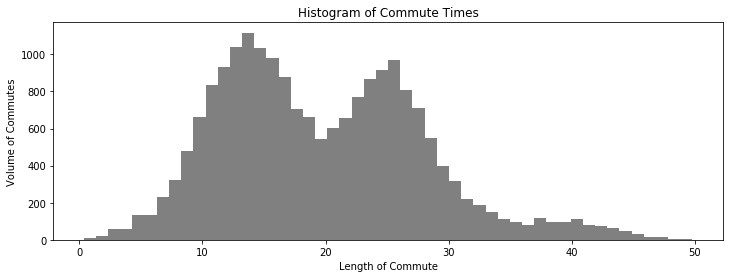

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['commute_time'].plot(
    ax=ax, kind='hist', bins=50, color="grey")
ax.set_title("Histogram of Commute Times")
ax.set_xlabel("Length of Commute")
ax.set_ylabel("Volume of Commutes")

### FIXME: No solution to discussion questions posed below

**Discussion.**

Discuss multi-modal nature.  What could be causing that?  **A:** We may have different subpopulations in the data with different commute time behavior. Transportation type is a possibility.

__________
Notes (markdown):

In [8]:
# Scratch area (code)

## Distribution of Time of Day

We'd like to draw a histogram of time of day, but this is not easy to do on the raw timestamp data.  To make our lives easy, we'll convert this into a decimal between zero and twenty-four.

In [9]:
def timestamp_to_decimal(ts):
    """Convert a timestamp datum into a decimal between zero and twenty-four.
    
    Parameters
    ----------
    ts: pd.Series of datetime.
    """
    return ts.dt.hour + (1/60)*ts.dt.minute

train_data_raw['time_of_day'] = timestamp_to_decimal(
    train_data_raw['time_of_day_ts'])
test_data_raw['time_of_day'] = timestamp_to_decimal(
    test_data_raw['time_of_day_ts'])

Notice how we have to apply the **same transformation** to our training and testing data.  I'll show you a trick soon that will save us some trouble.

Text(0, 0.5, 'Volume of Commutes')

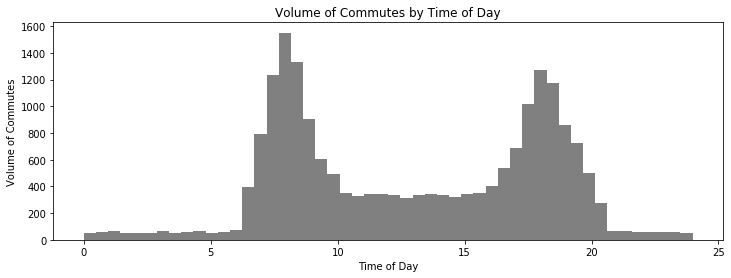

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['time_of_day'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Volume of Commutes by Time of Day")
ax.set_xlabel("Time of Day")
ax.set_ylabel("Volume of Commutes")

**Discussion**

We would expect high volume times to have longer commutes.  Plotting the commute time by the time of day may give some insight into the situation.

__________
Notes (markdown):

In [11]:
# Scratch area (code)

## Distance of Commute

### FIXME: These are better descriptions of euclidean and taxi cab difference 

The distance of the commute is not explicitly included in the dataset!  Instead, we have the coordinates of the source and destination of the commute.  This should allow us to calculate the distance of the commute, but we have a couple of options:

  - The **Euclidean Distance** is the straight line distance between the source and the target.  It is calculated from the usual formula inspired by the Pythagorean Theorem.

In [12]:
def euclidean_distance(source_x, source_y, target_x, target_y):
    return np.sqrt((source_x - target_x)**2 + (source_y - target_y)**2)

train_data_raw['euclidean_distance'] = euclidean_distance(
    train_data_raw['source_latitude'], train_data_raw['source_longitude'],
    train_data_raw['destination_latitude'], train_data_raw['destination_longitude'])
test_data_raw['euclidean_distance'] = euclidean_distance(
    test_data_raw['source_latitude'], test_data_raw['source_longitude'],
    test_data_raw['destination_latitude'], test_data_raw['destination_longitude'])

Text(0, 0.5, 'Volume of Commutes')

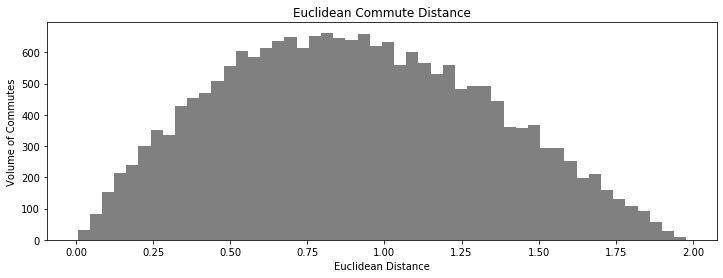

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['euclidean_distance'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Euclidean Commute Distance")
ax.set_xlabel("Euclidean Distance")
ax.set_ylabel("Volume of Commutes")

  - The **Taxicab Distance** is the total distance a car would travel between the source and destination coordinates *if it only traveled parallel to the x and y axes*.

In [14]:
def taxicab_distance(source_x, source_y, target_x, target_y):
    return np.abs(source_x - target_x) + np.abs(source_y - target_y)

train_data_raw['taxicab_distance'] = taxicab_distance(
    train_data_raw['source_latitude'], train_data_raw['source_longitude'],
    train_data_raw['destination_latitude'], train_data_raw['destination_longitude'])
test_data_raw['taxicab_distance'] = taxicab_distance(
    test_data_raw['source_latitude'], test_data_raw['source_longitude'],
    test_data_raw['destination_latitude'], test_data_raw['destination_longitude'])

Text(0, 0.5, 'Volume of Commutes')

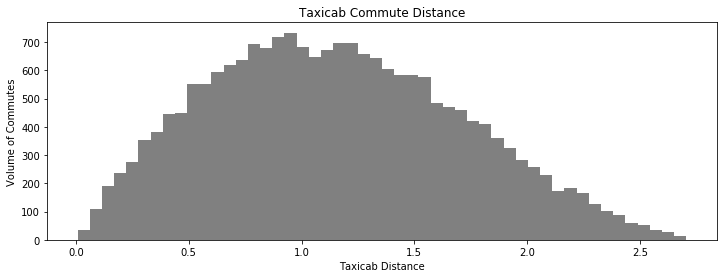

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['taxicab_distance'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Taxicab Commute Distance")
ax.set_xlabel("Taxicab Distance")
ax.set_ylabel("Volume of Commutes")

**Discussion**

Which distance measure do you think more likely to be related to the commute time?  Why?

In [16]:
# Scratch area (code)

### Challenge:
The code above was a lot to read and pretty repetitious.
We've mentioned the idea of avoiding repeated code where possible.
What could we do to avoid having to type the same code multiple times?

In [17]:
# Use this template to start if you want. 
# The docstring format below is one common convention.
# There are other good conventions represented elsewhere in FH materials.
# None of these is exactly right or wrong, but the important things are consistency and clarity.
def create_distance_features(df):
    """Describe what the function does here.
    
    Parameters
    ----------
    df: Important notes about our argument df here.
    """
    pass
# I've included a possible solution at the bottom of the document.

### FIXME: All of the above content is a direct copy of the last class

# Relationship Visualizations

## The Effect Of Commute Type on Commute Time

Let's try to look into the relationship between the commute type and commute time.  We have hypothesized that the commute type may have something to do with the multi-modal behaviour of commute time.

A powerful technique in this area is the principle of **small multiples**, draw many small separate plots in a way that the readers eye can easily compare them.

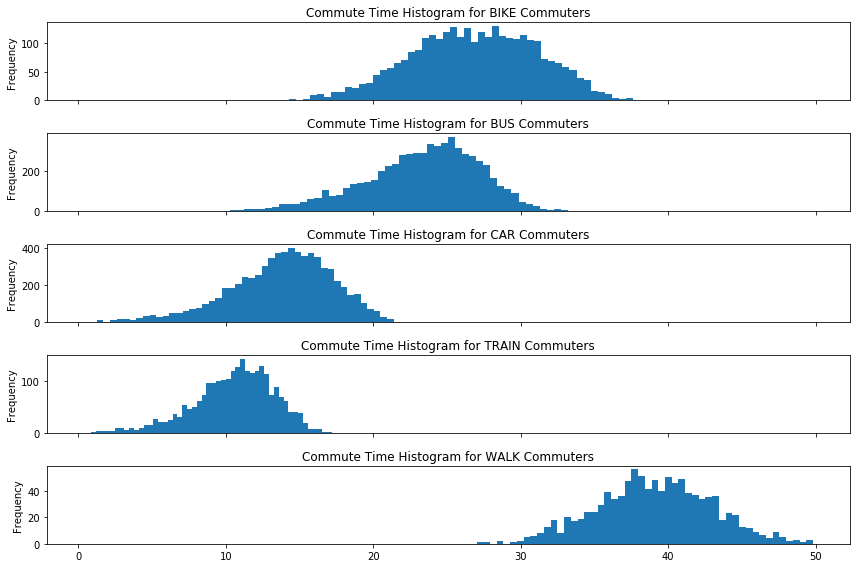

In [18]:
# Get a list of all the unique commute types.
commute_types = np.unique(train_data_raw['commute_type'])

# We want one axis (i.e. on plotting area) for each commute type.
# Note the sharex argument, this forces all out plots to have the 
# same x-axis range.
fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

# Subset the data by each commute type, then plot a histogram of commute
# times for each separate commute type individually.
for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_for_commute_type['commute_time'].plot(ax=ax, kind="hist", bins=50)
    ax.set_title("Commute Time Histogram for {0} Commuters".format(
        commute_type))

fig.tight_layout()

In [19]:
commute_types

array(['BIKE', 'BUS', 'CAR', 'TRAIN', 'WALK'], dtype=object)

It looks like the commute type definitely has an effect.

The results here are intuitive:  train commutes are speedy, while walking or biking to work takes longer.

__________
Notes (markdown):

In [20]:
# Scratch area (code)

### FIXME: Maybe provide more inline comments to explain what is happening in the chunk below?
### FIXME: should we use plot9 to plot since that was what was covered in intro?

Here's an alternative visualization of this effect (though making this one is a bit more involved).

In [21]:
def convert_to_numeric(categorical):
    classes = list(sorted(categorical.unique()))
    classes_mapping = {cls: i for i, cls in enumerate(classes)}
    classes_inv_mapping = {i: cls for i, cls in enumerate(classes)}
    classes_numeric = categorical.apply(lambda cls: classes_mapping[cls])
    return classes_numeric, classes_inv_mapping

def categorical_plot(ax, categorical, y, jitter_width=0.1, box=True):
    numeric, classes_mapping = convert_to_numeric(categorical)
    # This is called adding "jitter" to a scatterplot.
    noise = np.random.normal(0.0, jitter_width, size=len(categorical))
    ax.scatter(numeric + noise, y, color="grey", alpha=0.1, label="Data")
    
    box_data = list(y.groupby(numeric))
    if box:
        ax.boxplot([data for _, data in box_data], positions=range(len(box_data)))
    ax.set_xticks(list(classes_mapping))
    ax.set_xticklabels([classes_mapping[name] for name, _ in box_data])

Text(0.5, 1.0, 'Effect of Commute Type on Commute Time')

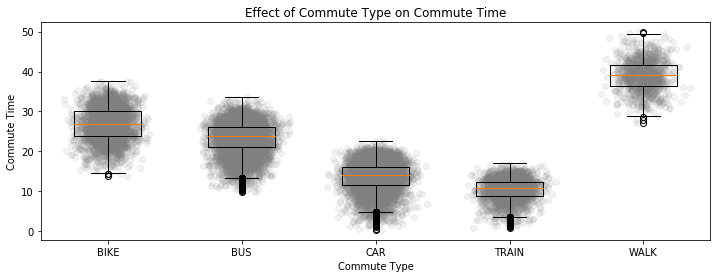

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))

categorical_plot(ax, train_data_raw['commute_type'], train_data_raw['commute_time'])
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")

### FIXME: Maybe link out for more info on boxplots?

This tells the same story in a different way.  Here we see each individual commute time as a point, so all the data is represented exactly.  Each cloud of points are the commute times for each individual type of commute.

The left-right scatter within each type of commute is not meaningful, it just serves to spread the points out so our eye can get an idea of what is going on.  If we take away the scatter, it looks really bad:

Text(0.5, 1.0, 'Effect of Commute Type on Commute Time')

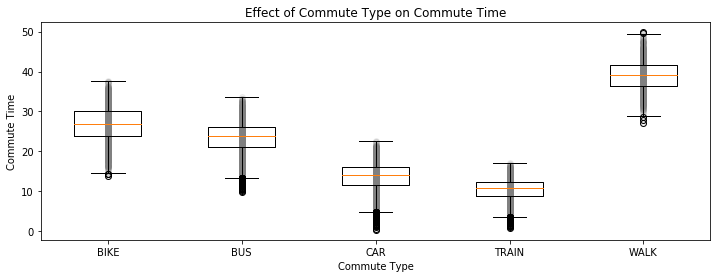

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))

categorical_plot(ax, 
                 train_data_raw['commute_type'], 
                 train_data_raw['commute_time'],
                 jitter_width=0.0)
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")

Not as good!

### FIXME: Discussion prompt needs solution

**Discussion**

Do you expect commute type to be predictive of commute time?

__________
Notes (markdown):

In [24]:
# Scratch area (code)

## The Effect of Commute Distance on Commute Time

### FIXME: Illuminating of what? 

A scatter plot of commute time by commute distance can be illuminating.

Text(0.5, 1.0, 'Commute Time by Euclidean Commute Distance')

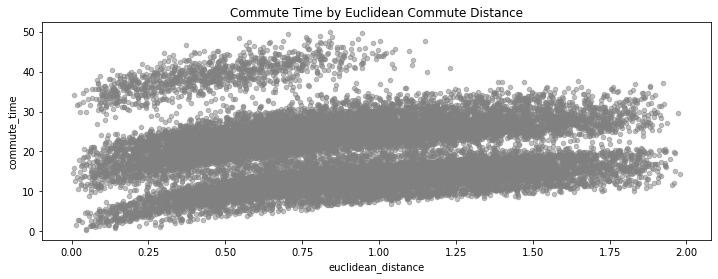

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='euclidean_distance', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Euclidean Commute Distance")

Text(0.5, 1.0, 'Commute Time by Taxicab Commute Distance')

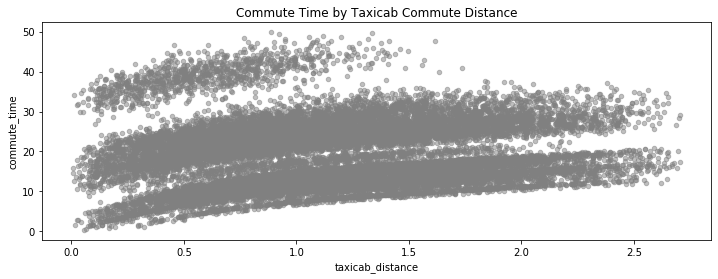

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Taxicab Commute Distance")

There is clearly a relationship between commute distance and commute time!  Though it is subtle:

  - There is *definitely* some overall relationship between the distance of the commute and the time of the commute.  Commutes covering a larger distance tend to take longer, which makes intuitive sense.
  - There is some interesting *banding* in these plots.  The relationships seem to fall into different categories.
  - The structure of the Taxicab distance plot is more defined than the structure of the Euclidean distance plot.  This maybe leads us to suspect that the taxicab distance is closer to capturing some essential truth of the situation.

Let's look into the banding.  We suspect that each defined band is some subpopulation of our commuters.  We have a clear candidate for what this could be, our commute type variable.

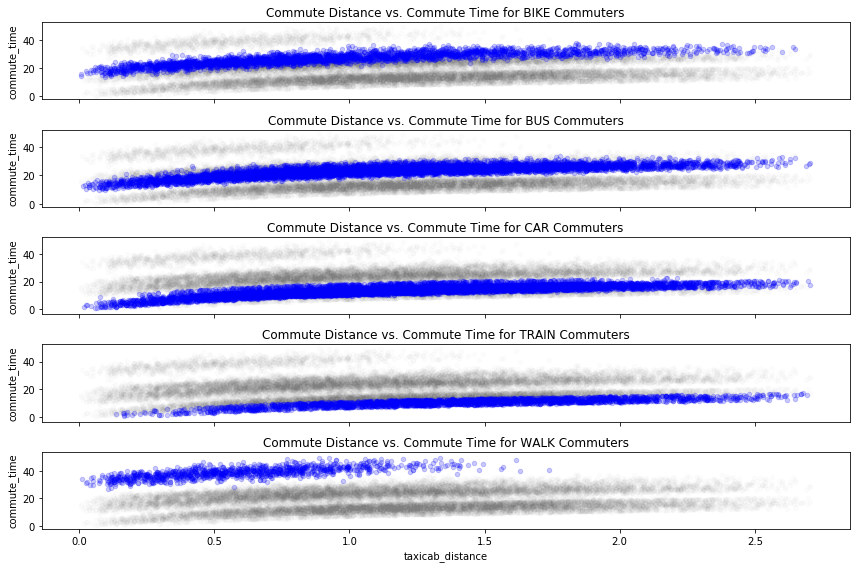

In [27]:
# This code is based on the example from earlier which creates histograms of 
# commute time for each individual commute type.
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='blue', alpha=0.2)
    ax.set_title("Commute Distance vs. Commute Time for {0} Commuters".format(
        commute_type))

fig.tight_layout()

We see clearly that the banding structure in the scatterplot is caused by the different types of commute.

__________
Notes (markdown):

In [28]:
# Scratch area (code)

## The Effect of Time of Day on Commute Time

Finally, let's look into the relationship between the commute time and the time of day.

Text(0.5, 1.0, 'Commute Time by Time of Day')

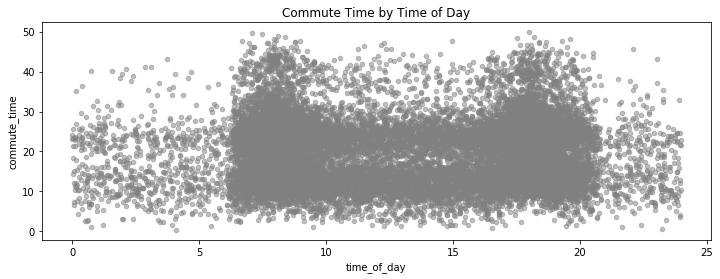

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='time_of_day', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Time of Day")

We again see some banding structure, so lets break it out by commute type to get a clearer picture of what's going on.

### FIXME: is the plot below labled correctly? Should be commute time vs commute time of day?

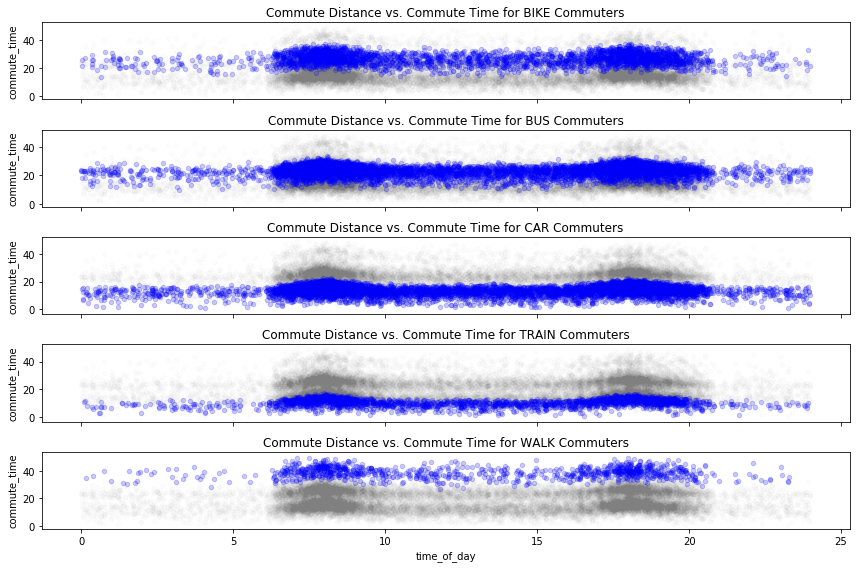

In [30]:
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='time_of_day', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='time_of_day', y='commute_time',
        color='blue', alpha=0.2)
    ax.set_title("Commute Distance vs. Commute Time for {0} Commuters".format(
        commute_type))

fig.tight_layout()

Similar to before, the bands are caused by the different commute types.

The relationship between time of day and commute time is subtle.  It's definitely not an increasing style of relationship.  Instead, it looks like commute times are largely driven by the distance, but they tend to be longer during high traffic times of day.

__________
Notes (markdown):

In [31]:
# Scratch area (code)

# Linear Regression: The Classic Workhorse of Predictive Modeling

### FIXME: Add link to linear regression from concepts course, maybe link out to something more technical also

Our goal now is to use the information we've learned from data exploration to build a predictive model that uses the features in the data to make a predicton of commute time.

The most important foundational technique for doing this is called **linear regression**.

## Using Commute Type to Predict Commute Time

Let's start with the commute type features.  We are almost certain from our data exploration that this feature has a strong influence on the commute time, so let's see if we're right.

### FIXME: commute time is a numeric variable? Might mean commute type

Its a general fact about predictive models that they cannot handle raw categorical data, like our commute time column.  Instead, whenever you would like to use a categorical measurement to make predictions, it is necessary to turn it into some number of **indicator variables**, usually one for each category.

In [32]:
def create_indicator_features(feature, leave_one_out=True):
    # Sort the levels so we always get the same ordering of new features.
    levels = list(sorted(np.unique(feature)))
    # If we need to leave one out to avoid identifiability issues, we will 
    # leave out the *last* level, in sorted order.
    if leave_one_out:
        levels = levels[:-1]
    indicator_features = []
    for level in levels:
        indicator_feature = (feature == level)
        indicator_feature_name = "is_{0}".format(level)
        indicator_features.append(
            pd.Series(indicator_feature, 
                      name=indicator_feature_name, 
                      index=feature.index,
                      dtype=int))
    return pd.concat(indicator_features, axis=1)

In [33]:
commute_type_features_train = create_indicator_features(train_data_raw['commute_type'])
commute_type_features_test = create_indicator_features(test_data_raw['commute_type'])

commute_type_features_train.head()

,is_BIKE,is_BUS,is_CAR,is_TRAIN
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,0,1


In [34]:
train_data_raw = pd.concat([train_data_raw, commute_type_features_train], axis=1)
test_data_raw = pd.concat([test_data_raw, commute_type_features_test], axis=1)

train_data_raw.head()

,Unnamed: 0,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day_ts,commute_type,commute_time,time_of_day,euclidean_distance,taxicab_distance,is_BIKE,is_BUS,is_CAR,is_TRAIN
0,0,-0.182809,0.361579,0.485623,0.300347,2018-08-13 16:56:00,BUS,25.156297,16.933333,0.671231,0.729664,0,1,0,0
1,1,0.160297,0.064330,0.702545,-0.116307,2018-08-13 18:19:00,CAR,12.937429,18.316667,0.571544,0.722885,0,0,1,0
2,2,0.762229,0.486693,0.197252,0.790051,2018-08-13 17:36:00,BIKE,29.013729,17.600000,0.641268,0.868335,1,0,0,0
3,3,0.187947,0.508487,-0.372924,-0.914006,2018-08-13 07:41:00,CAR,18.215423,7.683333,1.529073,1.983364,0,0,1,0
4,4,-0.431013,-0.600620,0.729273,0.215633,2018-08-13 15:56:00,TRAIN,11.196802,15.933333,1.418637,1.976539,0,0,0,1


We're prepared now.

We're going to fit a linear regression model which uses the commute type information to predict the commute distance.  The result of this will be an equation:

$$ \text{Commute Time} \approx \beta_0 + \beta_1 \times \text{is_BIKE} + \beta_2 \times \text{is_BUS} + \beta_3 \times \text{is_CAR} + \beta_4 \times \text{is_TRAIN} $$

The $\beta$ things are just numbers.  The whole idea is to use the **data** to choose the numbers $\beta_0, \beta_1, \ldots, \beta_4$ so that the equation above is the **most descriptive of the data possible**.

When we call the `LinearRegression.fit` function below, this is what's happening.

In [35]:
feature_names = ['is_BIKE', 'is_BUS', 'is_CAR', 'is_TRAIN']

train_data_only_commute_type = train_data_raw.loc[:, feature_names]
test_data_only_commute_type = test_data_raw.loc[:, feature_names]

In [36]:
model_only_commute_type = LinearRegression()
model_only_commute_type.fit(train_data_only_commute_type, train_data_raw['commute_time'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Once we've fit the model to our data, the beta numbers are available from the model object:

  - The `model.intercept_` attribute contains $\beta_0$.
  - The `model.coef_` attribute contains $\beta_1, \beta_2, \ldots$

In [37]:
model_only_commute_type.intercept_

39.05219308911751

In [38]:
model_only_commute_type.coef_

array([-12.22137668, -15.70403129, -25.29156173, -28.49699936])

Unfortunately, the model object does **not** remember the names of the features, so let's write a function to stitch together the names of the features with the values of the betas.

In [39]:
def print_betas(model, feature_names):
    feature_names = ["Intercept"] + feature_names
    betas = [model.intercept_] + list(model.coef_)
    for name, beta in zip(feature_names, betas):
        print("{0:<20}: {1:2.2f}".format(name, beta))

In [40]:
print_betas(model_only_commute_type, feature_names)

Intercept           : 39.05
is_BIKE             : -12.22
is_BUS              : -15.70
is_CAR              : -25.29
is_TRAIN            : -28.50


Now let's interpret this in light of our equation:

$$ \begin{align} \text{Commute Time} \ \approx \ & \beta_0 + \beta_1 \times \text{is_BIKE} \\&+ \beta_2 \times \text{is_BUS} \\&+ \beta_3 \times \text{is_CAR} \\&+ \beta_4 \times \text{is_TRAIN}\\ \end{align} $$

Which we can now plug numbers into:

$$ \begin{align} \text{Commute Time} \ \approx \ & 39.05 - 12.22 \times \text{is_BIKE} \\&- 15.70 \times \text{is_BUS} \\&- 25.29 \times \text{is_CAR} \\&- 28.50 \times \text{is_TRAIN}\\ \end{align} $$

We can play with this a bit to get some intuition.  For example, the predicted commute time for bike commuters is:

$$ \text{Commute Time} \approx 39.05 - 12.22 \times 1 - 15.70 \times 0 - 25.29 \times 0 - 28.50 \times 0 = 26.83 $$

And the predicted commute time for train commuters is:

$$ \text{Commute Time} \approx 39.05 - 12.22 \times 0 - 15.70 \times 0 - 25.29 \times 0 - 28.50 \times 1 = 10.55 $$

### FIXME: Need a solution for this discussion prompt

**Discussion:**

How can we get the predicted commute time for walk commuters?

__________
Notes (markdown):

In [41]:
# Scratch area (code)

### FIXME: Many times the verbage uses the word "this" it is unclear what "this" refers to

Working though this by hand (there are better ways to do this, I'll show you soon), we get the following predicted values for each commute type.

In [42]:
predictions_by_commute_type = {
    'BIKE': 26.83,
    'BUS': 23.25,
    'CAR': 13.75,
    'TRAIN': 10.55,
    'WALK': 39.05
}

Let's superimpose this on our scatter plot of this relationship from earlier to hopefully see what's going on:

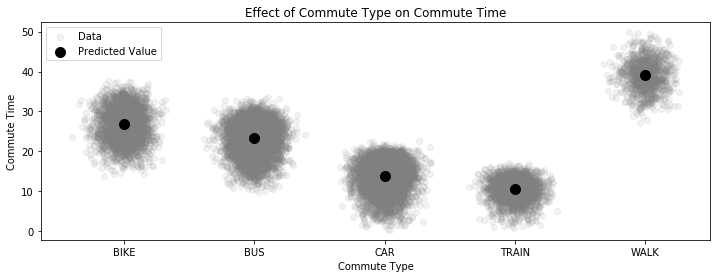

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))

categorical_plot(ax, train_data_raw['commute_type'], train_data_raw['commute_time'], box=False)
ax.scatter(range(5), predictions_by_commute_type.values(),
           color="black", s=100, label="Predicted Value")
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")
ax.legend()

This looks reasonable.  Although the actual commute times vary a lot within each group, the predictions from the model find the center of each group.  This is about the best we could ask for.

__________
Notes (markdown):

In [44]:
# Scratch area (code)

## Using Commute Distance to Predict Commute Time

Now lets turn to a different type of variable, the commute distance.

Here's our plot of the relationship from earlier:

Text(0.5, 1.0, 'Commute Time by Taxicab Commute Distance')

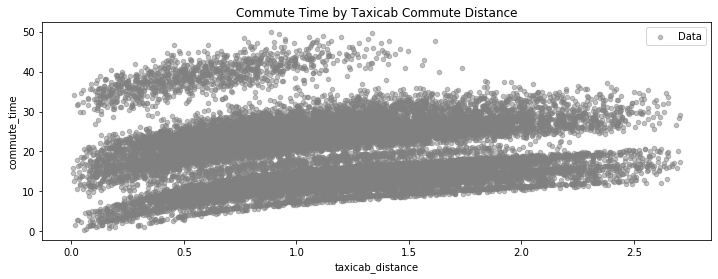

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.5, label="Data")
ax.set_title("Commute Time by Taxicab Commute Distance")

We saw that the commute time tends to increase with the distance covered.

Whereas our previous example used a categorical feature in the model, this time we have a **continuous** feature.  There are many ways to handle continuous features in a linear regression model, but we will focus on the most basic way today, fitting a line through the feature.  This will give us an equation like:

$$ \text{Commute Time} \approx \beta_0 + \beta_1 \times \text{Commute Distance} $$

This is actually easier than before, we don't need to fuss with the feature at all, since it is already numeric (as opposed to the commute type feature, which was not).

In [46]:
feature_names = ['taxicab_distance']

train_data_only_distance = train_data_raw.loc[:, feature_names]
test_data_only_distance = test_data_raw.loc[:, feature_names]

In [47]:
model_only_distance = LinearRegression()
model_only_distance.fit(train_data_only_distance, train_data_raw['commute_time'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
print_betas(model_only_distance, feature_names)

Intercept           : 18.43
taxicab_distance    : 1.14


So we got the following equation which best describes our data:

$$ \text{Commute Time} \approx 18.43 + 1.14 \times \text{Commute Distance} $$

It's good that the coefficient of commute distance came out to a **positive** number.  At the very least our model confirms that longer distances are paired with longer commute times.  If it had come out the other way around, we would have reason to doubt our work!

The equation we received from the model describes a line (it looks like `m x + b`, in classic algebra style).  This observation allows us to plot the relationship between commute time, and our prediction of commute time.

In [49]:
def plot_line(ax, slope, intercept, linewidth=3, color="black", label=""):
    t = np.linspace(0.0, 3.0, num=250)
    ax.plot(t, intercept + slope * t, label=label, 
            linewidth=linewidth, color=color)

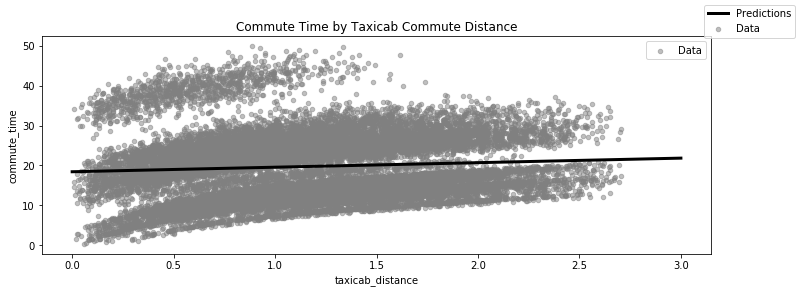

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.5, label="Data")
plot_line(ax, model_only_distance.coef_, model_only_distance.intercept_, label="Predictions")
ax.set_title("Commute Time by Taxicab Commute Distance")
fig.legend()

### FIXME: Need solution to discussion prompt, more text on why this isn't a good outcome

Hmm, not so pretty.

**Discussion**

Why does this line look so flat?  Is there any way we can remedy it?

__________
Notes (markdown):

In [51]:
# Scratch area (code)

## Using Both to Predict Commute Time

To correct the bad fit of the last time, we can use **both** sets of features in a linear regression.  This results in an equation like:

$$ \begin{align} \text{Commute Time} \ \approx \ & \beta_0 + \beta_1 \times \text{Commute Time} \\&+ \beta_2 \times \text{is_BIKE} \\&+ \beta_3 \times \text{is_BUS} \\&+ \beta_4 \times \text{is_CAR} \\&+ \beta_5 \times \text{is_TRAIN}\\ \end{align} $$

Note that we are mixing two different types of variables here.

  - The commute time variable is continuous, and its coefficient $\beta_1$ represents a slope.
  - The indicator variables are on or off, and their coefficients $\beta_2, \beta_3, \ldots$ represent simple additive adjustments.
  
I'll show you more clearly what I mean after we fit the model.

In [52]:
feature_names = ['is_BIKE', 'is_BUS', 'is_CAR', 'is_TRAIN', 'taxicab_distance']

train_data_both_distance_and_type = train_data_raw.loc[:, feature_names]
test_data_both_distance_and_type = test_data_raw.loc[:, feature_names]

In [53]:
model_both_distance_and_type = LinearRegression()
model_both_distance_and_type.fit(train_data_both_distance_and_type, train_data_raw['commute_time'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
print_betas(model_both_distance_and_type, feature_names)

Intercept           : 35.69
is_BIKE             : -14.20
is_BUS              : -18.71
is_CAR              : -28.59
is_TRAIN            : -32.96
taxicab_distance    : 5.50


So the equation our regression has found as most representative of the training data is:

$$ \begin{align} \text{Commute Time} \ \approx \ & 35.69 + 5.50 \times \text{Commute Distance} \\&  - 14.20 \times \text{is_BIKE} \\&- 18.71 \times \text{is_BUS} \\&- 28.59 \times \text{is_CAR} \\&- 32.96 \times \text{is_TRAIN}\\ \end{align} $$

Let's take a minute to think about what this means.

Take the case of **bus commuters**.  For these commuters, the feature `is_BUS` is equal to one, and all other commute type features are zero.  So, plugging these values into the above equation we get:

$$ \begin{align} \text{Commute Time for Bus Commuters} &= 35.69 + 5.50 \times \text{Commute Distance} - 18.71 \\ &= 16.98 + 5.50 \times \text{Commute Distance} \end{align} $$

So the model has given us a linear relationship that describes how the commute time varies with respect to commute distance for bus commuters.

Let's do one more, for walk commuters, all the commute type features are zero, and our equation reduces to:

$$\text{Commute Time for Walk Commuters} = 35.69 + 5.50 \times \text{Commute Distance} $$

We also get a linear relationship for walk commuters, though a different one than for bus commuters.

Let's plot and label all of these lines on the same axis, so we can easily compare them.

In [55]:
line_intercepts = {
    'BIKE': 35.69 - 14.20,
    'BUS': 35.69 - 18.71,
    'CAR': 35.69 - 28.59,
    'TRAIN': 35.69 - 32.96,
    'WALK': 35.69
}

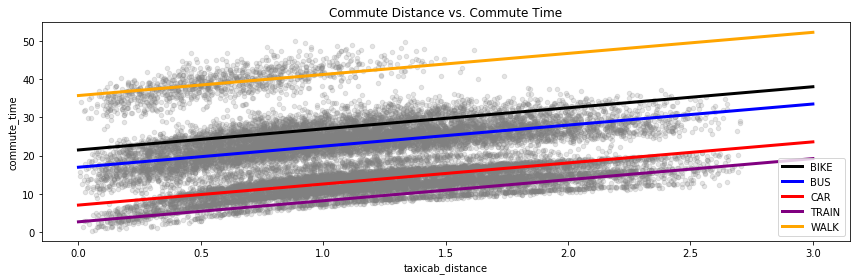

In [56]:
commute_types = np.unique(train_data_raw['commute_type'])
colors = ["black", "blue", "red", "purple", "orange"]

fig, ax = plt.subplots(figsize=(12, 4), sharex=True)

train_data_raw.plot(
    ax=ax, kind="scatter", 
    x='taxicab_distance', y='commute_time',
    color='gray', alpha=0.2)
for commute_type, color in zip(commute_types, colors):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    plot_line(ax, 5.50, line_intercepts[commute_type], 
              label=commute_type, color=color)
    ax.set_title("Commute Distance vs. Commute Time")
ax.legend()
fig.tight_layout()

We see that what we've managed to fit a sequence of **parallel lines**.  Each one describes the relationship between the commute distance and the commute time, but for a different type of commuter.

This is a pretty large increase in the fidelity of our model, and the fit is starting to look pretty good.  This is even more evident if we break each line out into its own plot.

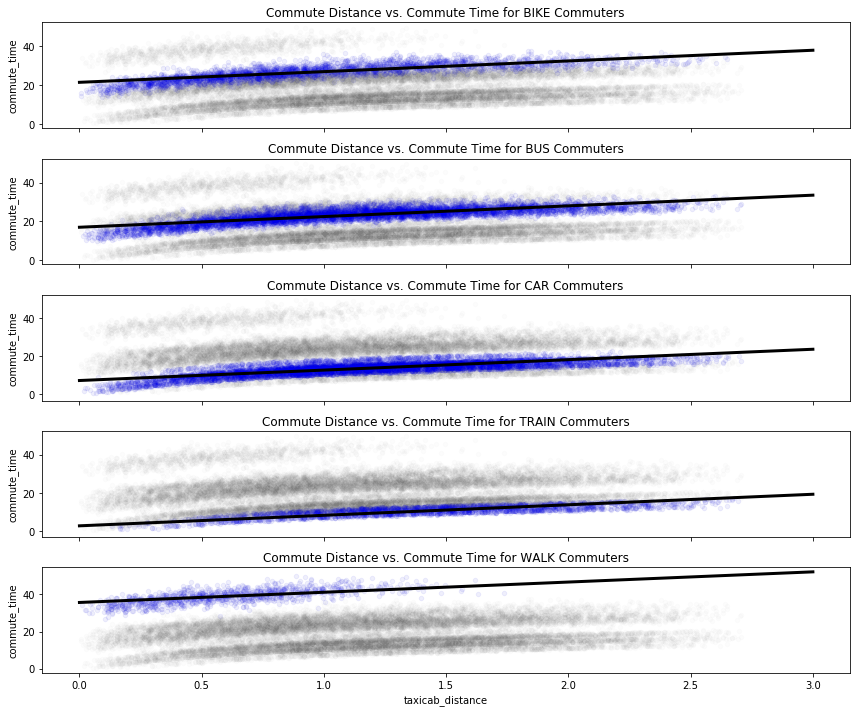

In [57]:
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 10), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='blue', alpha=0.05)
    plot_line(ax, 5.50, line_intercepts[commute_type])
    ax.set_title("Commute Distance vs. Commute Time for {0} Commuters".format(
        commute_type))

fig.tight_layout()

__________
Notes (markdown):

In [58]:
# Scratch area (code)

## So How Are These Lines Determined?

So far we have been satisfied with using python to fit or linear regressions, and have not thought much about how the coefficients are actually being determined, now lets loop back around and work this out.

**Let's simplify out life a bit so that the story is a bit easier to follow.**  Instead of working with the entire data set, lets subset to just bus commuters:

In [59]:
bus_commuter_mask = train_data_raw['commute_type'] == 'BUS'
bus_commuters_train = train_data_raw.loc[bus_commuter_mask, :]

Text(0.5, 1.0, 'Commute Time by Taxicab Commute Distance For Bus Commuters')

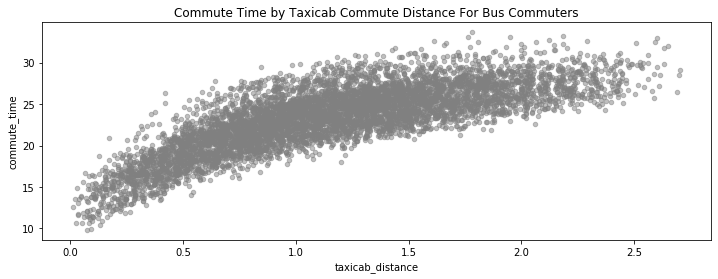

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))

bus_commuters_train.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                         color='gray', alpha=0.5)
ax.set_title("Commute Time by Taxicab Commute Distance For Bus Commuters")

And let's only use a hundred or so data points so we can draw out what is going on without being overwhelmed:

In [61]:
bus_commuters_train = bus_commuters_train.iloc[:100, :]

Text(0.5, 1.0, 'Commute Time by Taxicab Commute Distance For Bus Commuters')

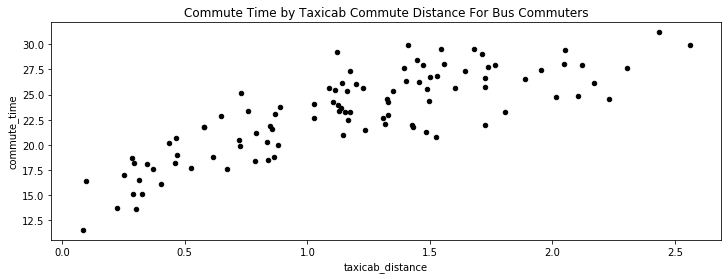

In [62]:
fig, ax = plt.subplots(figsize=(12, 4))

bus_commuters_train.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                         color='black', alpha=1.0)
ax.set_title("Commute Time by Taxicab Commute Distance For Bus Commuters")

Following the same methodology as before, let's fit a line to this dataset:

In [63]:
feature_names = ['taxicab_distance']
bus_commuters_only_distance = bus_commuters_train.loc[:, feature_names]

bus_only_model = LinearRegression()
bus_only_model.fit(bus_commuters_only_distance, bus_commuters_train['commute_time'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0.5, 1.0, 'Commute Time by Taxicab Commute Distance For Bus Commuters')

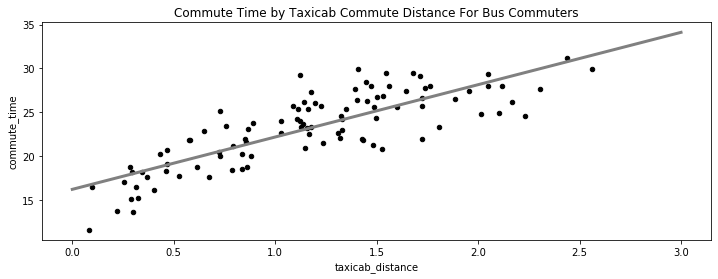

In [64]:
fig, ax = plt.subplots(figsize=(12, 4))

bus_commuters_train.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                         color='black', alpha=1.0)
plot_line(ax, bus_only_model.coef_, bus_only_model.intercept_, color="grey")
ax.set_title("Commute Time by Taxicab Commute Distance For Bus Commuters")

The question we want to answer is: **how was this line determined**.  So far we have just said:

> The line that best describes the data.

But what does "best" mean, how do we measure the "goodness" or "badness" of a line?

The answer involves the concept of **residuals**, which is everywhere in machine learning.  The residuals are the vertical distances from the predicted values (along the line in this case) to the actual data.

Text(0.5, 1.0, 'Commute Time by Taxicab Commute Distance For Bus Commuters')

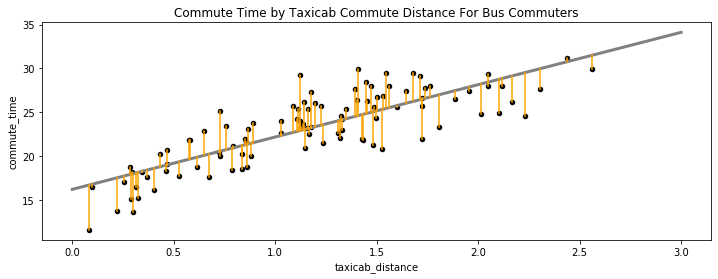

In [65]:
fig, ax = plt.subplots(figsize=(12, 4))

bus_commuters_train.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                         color='black', alpha=1.0)
plot_line(ax, bus_only_model.coef_, bus_only_model.intercept_, color="grey")

for (_, row), y in zip(bus_commuters_train.iterrows(),
                       bus_commuters_train['commute_time']):
    t = row['taxicab_distance']
    pred = bus_only_model.intercept_ + bus_only_model.coef_ * t
    ax.plot((t, t), (y, pred), color='orange')

ax.set_title("Commute Time by Taxicab Commute Distance For Bus Commuters")

The length of the residuals are a reasonable measure of the "goodness" of the prediction at some data point.

For reason that we must leave unexplored, instead it is the **square** of the length of the residuals that we use as our measure of "goodness".  Overall, we use the **mean length of the squared residuals** as an overall measure of quality for a given line.

Given all that, the principle we use to fit the line to data is:

> Among all possible lines, we prefer the one that minimizes the mean of the squared residuals.

This measurement of "badness" is called the **Mean Squared Error**.  As a formula, it looks like:

$$ \text{Mean Squared Error} = \frac{1}{\text{# of Datapoints}} \sum_i (y_i - \hat y_i)^2 $$

The $y_i$ and $\hat y_i$ notations are very traditional:

  - A $y_i$ is the actual measured target value for a single data point.
  - A $\hat y_i$ is the predicted value for a single data point.
  
So the sub-expression $y_i - \hat y_i$ is the difference between the actual and predicted values for a single data point.

**Discussion:**

What's the point of squaring the difference between actual and predicted here?

**Note:** Some people prefer the **Root Mean Squared Error** which is simply the square root of the mean squared error, since shares the same units of measurement as $y$.  Whichever you choose is mostly a matter of taste.

$$ \text{Root Mean Squared Error} = \sqrt{ \frac{1}{\text{# of Datapoints}} \sum_i (y_i - \hat y_i)^2 }$$

__________
Notes (markdown):

In [66]:
# Scratch area (code)

## Measuring The Predictive Power of The Models

Now that we've discussed the mean squared error as a measure of the quality of our predictions, we can write a quick function to calculate it for each of the three models we have created.

In [67]:
def mean_squared_error(actual, predicted):
    assert len(actual) == len(predicted)
    n = len(actual)
    return (1/n) * np.sum((actual - predicted)**2)

def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

Let's get the predicted values for all three of our models for all of our training data points.

In [68]:
only_commute_type_preds = model_only_commute_type.predict(
    train_data_only_commute_type)
only_distance_preds = model_only_distance.predict(
    train_data_only_distance)
both_distance_and_type_preds = model_both_distance_and_type.predict(
    train_data_both_distance_and_type)

Then use our functions to compute the root mean squared errors.

In [69]:
only_distance_rmse = root_mean_squared_error(
    only_distance_preds, train_data_raw['commute_time'])
only_commute_type_rmse = root_mean_squared_error(
    only_commute_type_preds, train_data_raw['commute_time'])
both_distance_and_type_rmse = root_mean_squared_error(
    both_distance_and_type_preds, train_data_raw['commute_time'])

In [70]:
print("Only Distance Model RMSE: {0:2.2f}".format(only_distance_rmse))
print("Only Commute Type Model RMSE: {0:2.2f}".format(only_commute_type_rmse))
print("Both Distance and Type RMSE: {0:2.2f}".format(both_distance_and_type_rmse))

Only Distance Model RMSE: 8.21
Only Commute Type Model RMSE: 3.67
Both Distance and Type RMSE: 2.27


It looks like our worst model was the only only using distance, and the best was the one that used both distance and commute type, which was more or less what we suspected from our visuals.

__________
Notes (markdown):

In [71]:
# Scratch area (code)

## Using Test Data

There's a subtle flaw in our model evaluation scheme.

Notice that the more complex models, i.e. the ones that had access to more features, always did better than those that had access to less.  This is **always** true, for the following reason.

Each model is determining the $\beta$s to use, but choosing the ones that **minimize** the mean squared error.  We are then using that **same** measurement to choose the most predictive model.  This is dangerous, any model with strictly more information than another will be able to use this information to lower the mean squared error measurement it is using to determine the best values of $\beta$, even if that extra information is just random garbage.

For this reason, we distinguish between two fundamental types of data:

  - **Training** data is the data used by the model to calculate the best values of $\beta$.  This data becomes polluted by the training process, and cannot be used to honestly compare different models that used it.
  - **Testing** data is any data **not** used by any of the models to calculate the best values of $\beta$.  This data is un-polluted, and has a fair view on the relative merits of the various models.

You may have noticed that whenever we created any features to use in our regression models, we did the same thing to both the training and test data (we loaded both sets at the start of the notebook).

When we used the `.fit` method to calculate the best $\beta$s, we **always** used only the training data!  So we can now use the test data to get a fair look at the models:

In [72]:
only_commute_type_preds = model_only_commute_type.predict(
    test_data_only_commute_type)
only_distance_preds = model_only_distance.predict(
    test_data_only_distance)
both_distance_and_type_preds = model_both_distance_and_type.predict(
    test_data_both_distance_and_type)

In [73]:
only_distance_rmse = root_mean_squared_error(
    only_distance_preds, test_data_raw['commute_time'])
only_commute_type_rmse = root_mean_squared_error(
    only_commute_type_preds, test_data_raw['commute_time'])
both_distance_and_type_rmse = root_mean_squared_error(
    both_distance_and_type_preds, test_data_raw['commute_time'])

In [74]:
print("Only Distance Model Test RMSE: {0:2.2f}".format(only_distance_rmse))
print("Only Commute Type Model Test RMSE: {0:2.2f}".format(only_commute_type_rmse))
print("Both Distance and Type Test RMSE: {0:2.2f}".format(both_distance_and_type_rmse))

Only Distance Model Test RMSE: 8.15
Only Commute Type Model Test RMSE: 3.65
Both Distance and Type Test RMSE: 2.27


### FIXME: Add more text below describing training vs testing data. "death" is not clear

In this simple case, the results are the same as using the training data.  This is because we have a lot of data, and are not fitting super sophisticated models.  In practice, using training data to evaluate models is **death** (a different **death** than the one arising from training models using test data, but similar in magnitude and finality).

__________
Notes (markdown):

In [75]:
# Scratch area (code)

# Random Forests

As a bonus, let's see how the linear regression methodology stands up to a more recent method of building predictive models: the Random Forests of Leo Breiman.

The philosophy of a random forest is very different to a linear regression:

  - **Linear Regression:** Study the data very hard, and make informed decision about what features to put in the model and how.  Fit one model that incorporates all this information.
  - **Random Forests:** Fit many models without worrying much about the way the data works, but take some steps to diversify the models.  Then combine the models by averaging their predictions.

In [76]:
random_forest = RandomForestRegressor(
    n_estimators=2000, max_features=4, min_samples_split=20)
random_forest.fit(train_data_both_distance_and_type, train_data_raw['commute_time'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
random_forest_preds = random_forest.predict(test_data_both_distance_and_type)

In [78]:
random_forest_rmse = root_mean_squared_error(
    random_forest_preds, test_data_raw['commute_time'])

In [79]:
print("Random Forest RMSE: {0:2.2f}".format(random_forest_rmse))

Random Forest RMSE: 2.15


The random forest pretty easily improves on the predictions of the linear regression.  Let's look at the basic reason why this model did better.

__________
Notes (markdown):

In [80]:
# Scratch area (code)

## Capturing Non-Linear Relationships

Recall out line of best fit to the bus commuters:

Text(0.5, 1.0, 'Commute Time by Taxicab Commute Distance For Bus Commuters')

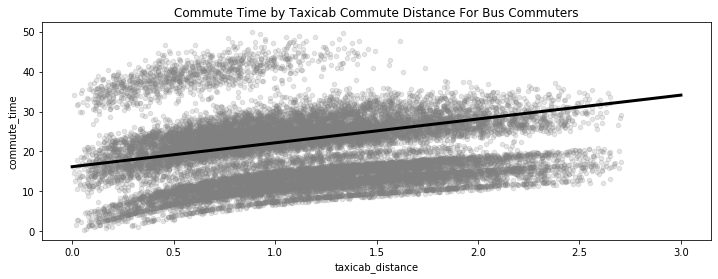

In [81]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.2)

plot_line(ax, bus_only_model.coef_, bus_only_model.intercept_, color="black")
ax.set_title("Commute Time by Taxicab Commute Distance For Bus Commuters")

It's pretty clear that a line is not the best choice of curve here.  The general trend of the data steepens for small commute distances and levels off for large distances.

One of the reasons random forests tends to be more powerful than linear regression is that it is able to fit more flexible shapes to data.

Let's plot out the curve that the random forest fit to our bus commuters:

In [82]:
one_record = train_data_both_distance_and_type.iloc[:1, :]
def create_bus_records(distances):
    records = []
    for d in distances:
        record = one_record.copy()
        record['taxicab_distance'] = d
        records.append(record)
    return pd.concat(records)

In [83]:
ts = np.linspace(0, 3.0, num=250)

ls = create_bus_records(ts)
preds = random_forest.predict(ls)

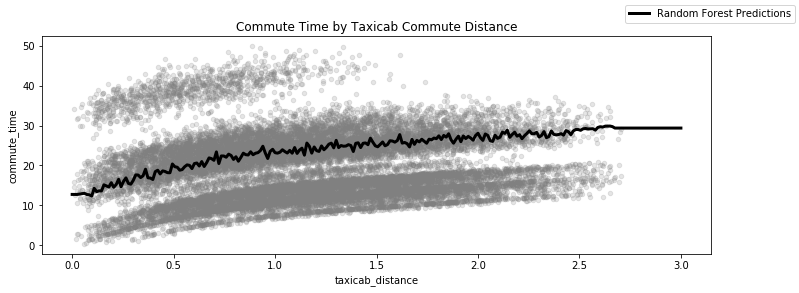

In [84]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.2)
ax.plot(ts, preds, color="black", linewidth=3, label= "Random Forest Predictions")
ax.set_title("Commute Time by Taxicab Commute Distance")
fig.legend()

__________
Notes (markdown):

In [85]:
# Scratch area (code)

### FIXME: More text context on random forest, need a wrap up section

### Notes, extras, solutions

In [86]:
# A possible solution to one of the questions above. Did yours look something like this?
def create_distance_features(df):
    """Add 'euclidean_distance' and 'manhattan_distance' feaures to a DataFrame.
    
    Parameters
    ----------
    df: pd.Dataframe with features 'source_latitude', 'source_longitude', 'destination_latitude', 
    and 'destination_longitude'.
    """
    coordinates = [df['source_latitude'], df['source_longitude'], 
                   df['destination_latitude'], df['destination_longitude']]
    df['euclidean_distance'] = euclidean_distance(coordinates)
    df['manhattan_distance'] = manhattan_distance(coordinates)
    return df